In [5]:
from torch.utils.data import DataLoader, Dataset
from transformers import BlipForConditionalGeneration, BlipProcessor
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [6]:
import torch
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class BDD100KDataset(Dataset):
    def __init__(self, image_dir, json_file, processor):
        self.image_dir = image_dir
        self.processor = processor
        self.data = []

        with open(json_file, 'r') as f:
            annotations = json.load(f)
            for item in annotations:
                image_name = item["name"]
                labels = [label["category"] for label in item.get("labels", [])]
                weather = item.get("attributes", {}).get("weather", "unknown")
                scene = item.get("attributes", {}).get("scene", "urban")
                time_of_day = item.get("attributes", {}).get("timeofday", "daytime")

                if labels:
                    label_desc = ", ".join(labels)
                else:
                    label_desc = "various elements"

                caption = (f"This is a {scene} street scene captured during {time_of_day}. "
                           f"The environment includes {label_desc} under {weather} weather conditions.")

                image_path = os.path.join(self.image_dir, image_name)
                if os.path.exists(image_path):
                    self.data.append((image_name, caption))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, caption = self.data[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        inputs = self.processor(images=image, text=caption, return_tensors="pt", padding="max_length", truncation=True)
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}

       
        image_tensor = transforms.ToTensor()(image)

        return inputs, image_tensor, caption 


In [ ]:
train_dataset = BDD100KDataset("/content/drive/MyDrive/bdd100k/images/100k/train", "/content/drive/MyDrive/bdd100k/labels/bdd100k_labels_images_train.json", processor)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
scaler = torch.cuda.amp.GradScaler()


In [12]:
from tqdm import tqdm

for epoch in range(50):  
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

    for batch, _, _ in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.cuda.amp.autocast():
            outputs = model(**batch, labels=batch['input_ids'])  
            loss = outputs.loss
            logits = outputs.logits

        
        if loss is not None:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

            # Calculate accuracy
            predictions = logits.argmax(dim=-1)
            correct += (predictions == batch['input_ids']).sum().item()
            total += batch['input_ids'].numel()
        else:
            print("Warning: Loss is None for this batch. Skipping optimization step.")

        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct / total * 100
    print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1:   0%|          | 0/577 [00:00<?, ?it/s]<ipython-input-12-7bb8864ccbfb>:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1: 100%|██████████| 577/577 [03:24<00:00,  2.82it/s, loss=0.0808]


Epoch 1, Training Loss: 0.0906, Accuracy: 83.31%


Epoch 2: 100%|██████████| 577/577 [03:19<00:00,  2.89it/s, loss=0.0454]


Epoch 2, Training Loss: 0.0572, Accuracy: 83.31%


Epoch 3: 100%|██████████| 577/577 [03:25<00:00,  2.81it/s, loss=0.04]


Epoch 3, Training Loss: 0.0482, Accuracy: 83.31%


Epoch 4: 100%|██████████| 577/577 [03:27<00:00,  2.79it/s, loss=0.0448]


Epoch 4, Training Loss: 0.0430, Accuracy: 83.31%


Epoch 5: 100%|██████████| 577/577 [03:24<00:00,  2.82it/s, loss=0.0236]


Epoch 5, Training Loss: 0.0398, Accuracy: 83.31%


Epoch 6: 100%|██████████| 577/577 [03:19<00:00,  2.89it/s, loss=0.0481]


Epoch 6, Training Loss: 0.0372, Accuracy: 83.31%


Epoch 7: 100%|██████████| 577/577 [03:33<00:00,  2.71it/s, loss=0.0537]


Epoch 7, Training Loss: 0.0351, Accuracy: 83.31%


Epoch 8: 100%|██████████| 577/577 [03:42<00:00,  2.59it/s, loss=0.0263]


Epoch 8, Training Loss: 0.0334, Accuracy: 83.31%


Epoch 9: 100%|██████████| 577/577 [03:43<00:00,  2.59it/s, loss=0.0167]


Epoch 9, Training Loss: 0.0316, Accuracy: 83.31%


Epoch 10: 100%|██████████| 577/577 [03:40<00:00,  2.62it/s, loss=0.0235]


Epoch 10, Training Loss: 0.0300, Accuracy: 83.31%


Epoch 11: 100%|██████████| 577/577 [03:23<00:00,  2.84it/s, loss=0.0416]


Epoch 11, Training Loss: 0.0290, Accuracy: 83.31%


Epoch 12: 100%|██████████| 577/577 [03:19<00:00,  2.90it/s, loss=0.0189]


Epoch 12, Training Loss: 0.0271, Accuracy: 83.31%


Epoch 13: 100%|██████████| 577/577 [03:19<00:00,  2.90it/s, loss=0.0153]


Epoch 13, Training Loss: 0.0259, Accuracy: 83.31%


Epoch 14: 100%|██████████| 577/577 [03:27<00:00,  2.78it/s, loss=0.0122]


Epoch 14, Training Loss: 0.0251, Accuracy: 83.31%


Epoch 15: 100%|██████████| 577/577 [03:19<00:00,  2.89it/s, loss=0.0281]


Epoch 15, Training Loss: 0.0238, Accuracy: 83.31%


Epoch 16: 100%|██████████| 577/577 [03:22<00:00,  2.85it/s, loss=0.0339]


Epoch 16, Training Loss: 0.0225, Accuracy: 83.31%


Epoch 17: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.0144]


Epoch 17, Training Loss: 0.0216, Accuracy: 83.31%


Epoch 18: 100%|██████████| 577/577 [03:19<00:00,  2.89it/s, loss=0.0156]


Epoch 18, Training Loss: 0.0205, Accuracy: 83.31%


Epoch 19: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.0386]


Epoch 19, Training Loss: 0.0195, Accuracy: 83.31%


Epoch 20: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.0519]


Epoch 20, Training Loss: 0.0194, Accuracy: 83.31%


Epoch 21: 100%|██████████| 577/577 [03:18<00:00,  2.90it/s, loss=0.0151]


Epoch 21, Training Loss: 0.0188, Accuracy: 83.31%


Epoch 22: 100%|██████████| 577/577 [03:19<00:00,  2.89it/s, loss=0.00624]


Epoch 22, Training Loss: 0.0181, Accuracy: 83.31%


Epoch 23: 100%|██████████| 577/577 [03:18<00:00,  2.90it/s, loss=0.00653]


Epoch 23, Training Loss: 0.0175, Accuracy: 83.31%


Epoch 24: 100%|██████████| 577/577 [03:18<00:00,  2.90it/s, loss=0.0176]


Epoch 24, Training Loss: 0.0165, Accuracy: 83.31%


Epoch 25: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.0155]


Epoch 25, Training Loss: 0.0160, Accuracy: 83.31%


Epoch 26: 100%|██████████| 577/577 [03:19<00:00,  2.89it/s, loss=0.0175]


Epoch 26, Training Loss: 0.0156, Accuracy: 83.31%


Epoch 27: 100%|██████████| 577/577 [03:19<00:00,  2.90it/s, loss=0.00759]


Epoch 27, Training Loss: 0.0153, Accuracy: 83.31%


Epoch 28: 100%|██████████| 577/577 [03:18<00:00,  2.90it/s, loss=0.0096]


Epoch 28, Training Loss: 0.0147, Accuracy: 83.31%


Epoch 29: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.00797]


Epoch 29, Training Loss: 0.0145, Accuracy: 83.31%


Epoch 30: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.00745]


Epoch 30, Training Loss: 0.0136, Accuracy: 83.31%


Epoch 31: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.00762]


Epoch 31, Training Loss: 0.0134, Accuracy: 83.31%


Epoch 32: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.00896]


Epoch 32, Training Loss: 0.0131, Accuracy: 83.31%


Epoch 33: 100%|██████████| 577/577 [03:17<00:00,  2.92it/s, loss=0.00806]


Epoch 33, Training Loss: 0.0126, Accuracy: 83.31%


Epoch 34: 100%|██████████| 577/577 [03:18<00:00,  2.90it/s, loss=0.0187]


Epoch 34, Training Loss: 0.0121, Accuracy: 83.31%


Epoch 35: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.0104]


Epoch 35, Training Loss: 0.0115, Accuracy: 83.31%


Epoch 36: 100%|██████████| 577/577 [03:17<00:00,  2.92it/s, loss=0.0129]


Epoch 36, Training Loss: 0.0116, Accuracy: 83.31%


Epoch 37: 100%|██████████| 577/577 [03:17<00:00,  2.92it/s, loss=0.0196]


Epoch 37, Training Loss: 0.0110, Accuracy: 83.31%


Epoch 38: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.00683]


Epoch 38, Training Loss: 0.0107, Accuracy: 83.31%


Epoch 39: 100%|██████████| 577/577 [03:17<00:00,  2.92it/s, loss=0.0117]


Epoch 39, Training Loss: 0.0102, Accuracy: 83.31%


Epoch 40: 100%|██████████| 577/577 [03:17<00:00,  2.92it/s, loss=0.0146]


Epoch 40, Training Loss: 0.0104, Accuracy: 83.31%


Epoch 41: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.00519]


Epoch 41, Training Loss: 0.0095, Accuracy: 83.31%


Epoch 42: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.00704]


Epoch 42, Training Loss: 0.0095, Accuracy: 83.31%


Epoch 43: 100%|██████████| 577/577 [03:17<00:00,  2.92it/s, loss=0.00952]


Epoch 43, Training Loss: 0.0090, Accuracy: 83.31%


Epoch 44: 100%|██████████| 577/577 [03:17<00:00,  2.92it/s, loss=0.00218]


Epoch 44, Training Loss: 0.0090, Accuracy: 83.31%


Epoch 45: 100%|██████████| 577/577 [03:17<00:00,  2.92it/s, loss=0.00348]


Epoch 45, Training Loss: 0.0085, Accuracy: 83.31%


Epoch 46: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.00369]


Epoch 46, Training Loss: 0.0089, Accuracy: 83.31%


Epoch 47: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.00932]


Epoch 47, Training Loss: 0.0080, Accuracy: 83.31%


Epoch 48: 100%|██████████| 577/577 [03:18<00:00,  2.90it/s, loss=0.00275]


Epoch 48, Training Loss: 0.0078, Accuracy: 83.31%


Epoch 49: 100%|██████████| 577/577 [03:18<00:00,  2.91it/s, loss=0.00423]


Epoch 49, Training Loss: 0.0075, Accuracy: 83.31%


Epoch 50: 100%|██████████| 577/577 [03:17<00:00,  2.92it/s, loss=0.0104]

Epoch 50, Training Loss: 0.0074, Accuracy: 83.31%


In [13]:
model.save_pretrained("./fine_tuned_blip2_bdd100k")
processor.save_pretrained("./fine_tuned_blip2_bdd100k")

[]

In [14]:
fine_tuned_model = BlipForConditionalGeneration.from_pretrained("./fine_tuned_blip2_bdd100k").to(device)

In [15]:
def generate_caption(image_path, model_to_use, title):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    caption_ids = model_to_use.generate(**inputs, max_length=60, num_beams=7, early_stopping=True, repetition_penalty=1.2)
    caption = processor.batch_decode(caption_ids, skip_special_tokens=True)[0]

    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f"{title}: {caption}", fontsize=12)
    plt.axis("off")
    plt.show()
    return caption


In [16]:
def visualize_sample(image_path):
    caption = generate_caption(image_path)
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(caption, fontsize=12)
    plt.axis("off")
    plt.show()

Generating captions before fine-tuning:


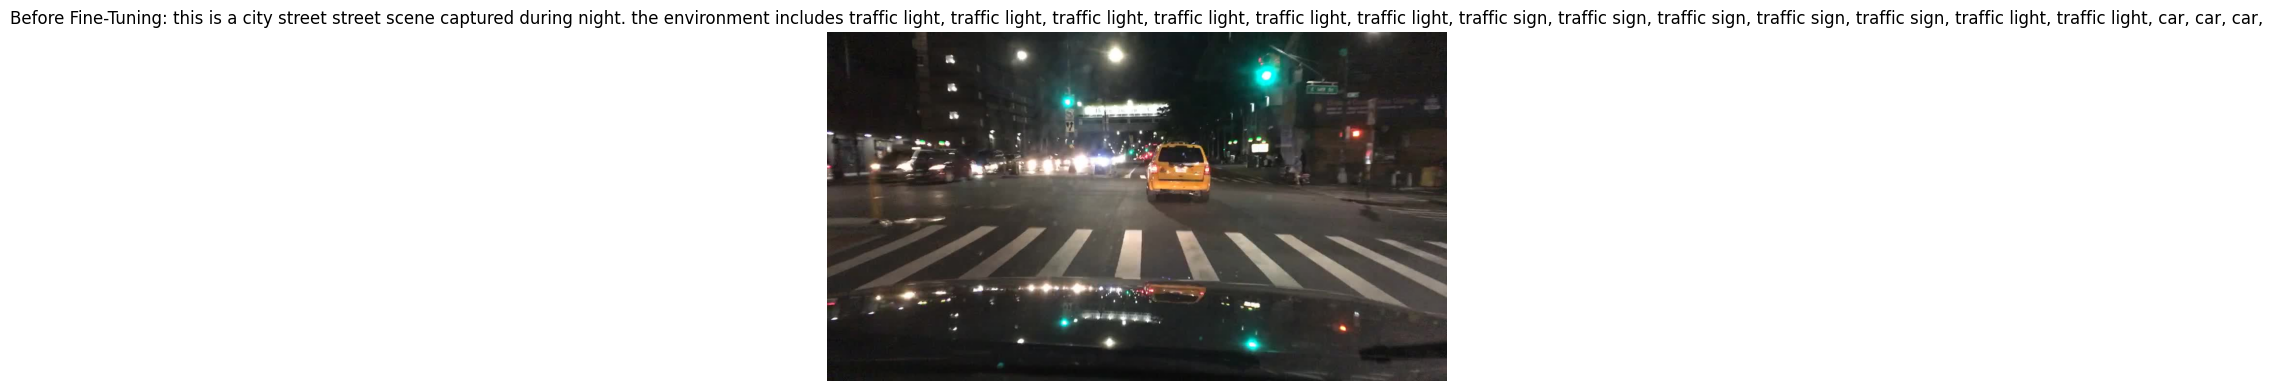

Generating captions after fine-tuning:


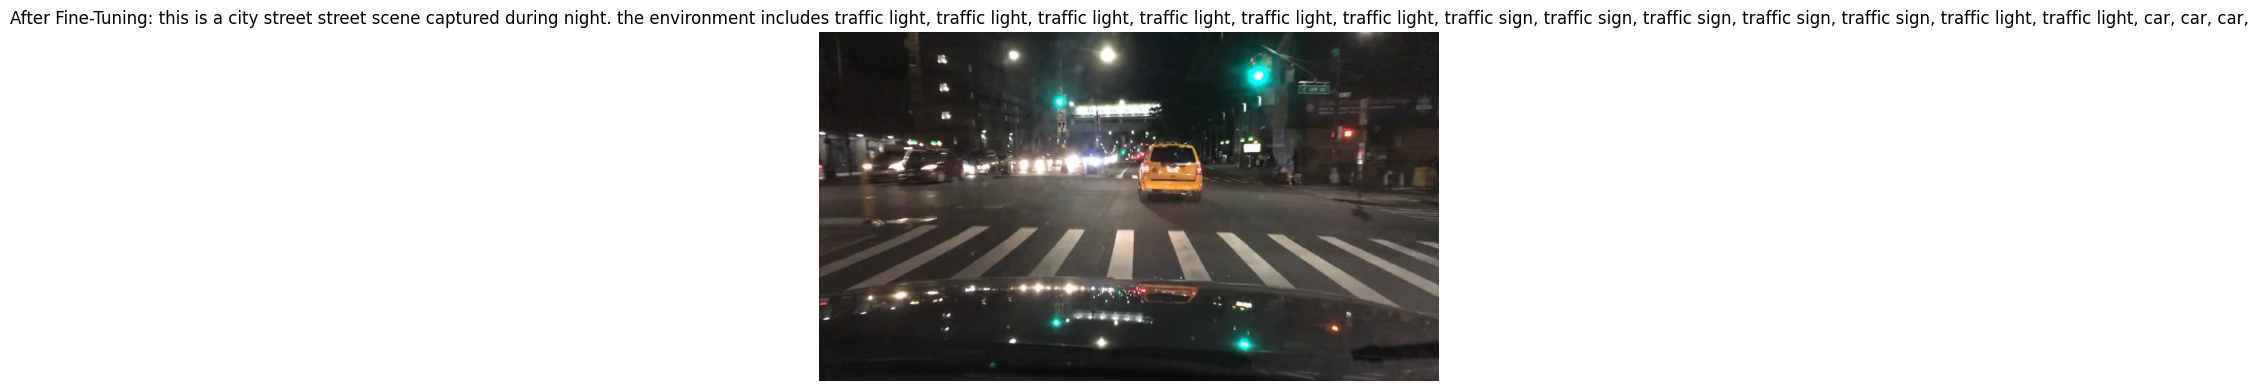

In [20]:
sample_image_path = "/content/drive/MyDrive/bdd100k/images/100k/train/068fa72c-06df5852.jpg"
print("Generating captions before fine-tuning:")
original_caption = generate_caption(sample_image_path, model, "Before Fine-Tuning")
print("Generating captions after fine-tuning:")
fine_tuned_caption = generate_caption(sample_image_path, fine_tuned_model, "After Fine-Tuning")

Generating captions before fine-tuning:


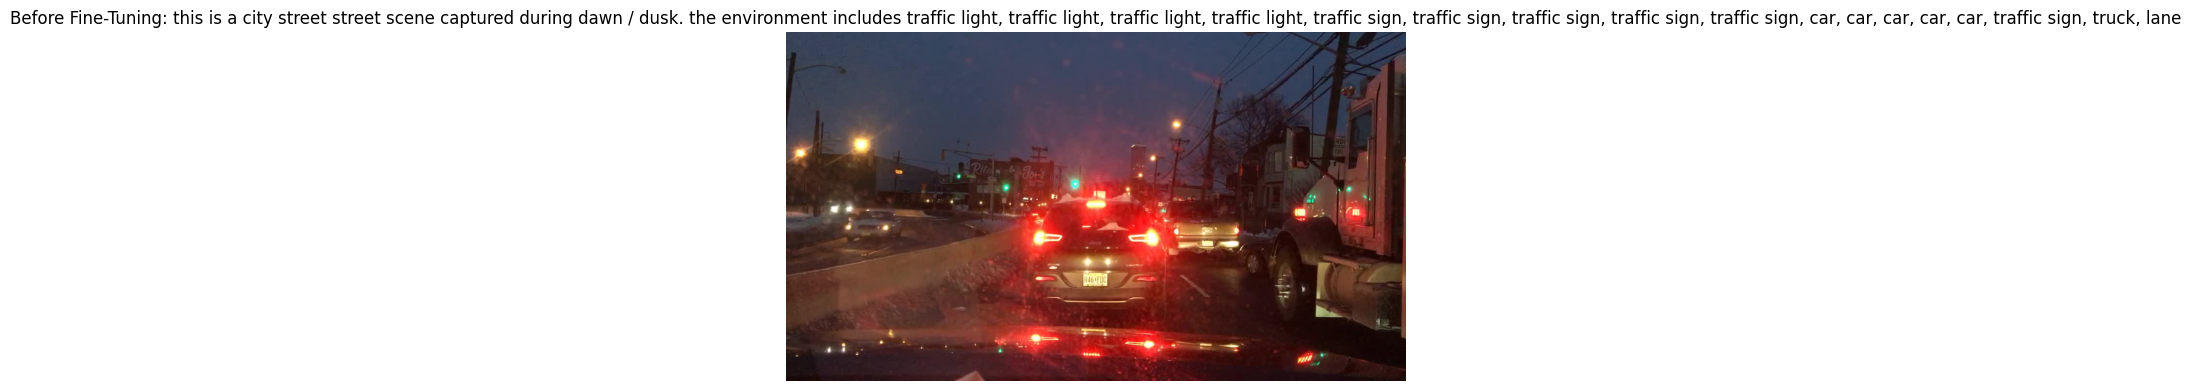

Generating captions after fine-tuning:


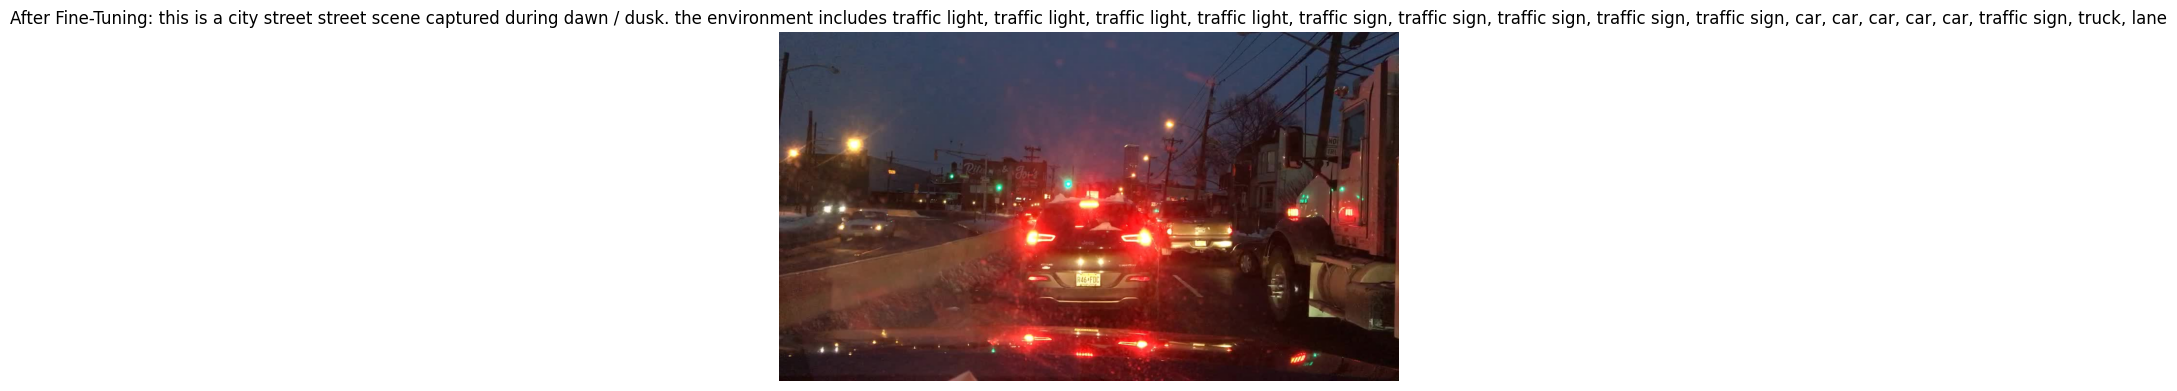

In [21]:
sample_image_path = "/content/drive/MyDrive/bdd100k/images/100k/train/152cb661-93a0f960.jpg"
print("Generating captions before fine-tuning:")
original_caption = generate_caption(sample_image_path, model, "Before Fine-Tuning")
print("Generating captions after fine-tuning:")
fine_tuned_caption = generate_caption(sample_image_path, fine_tuned_model, "After Fine-Tuning")

Generating captions before fine-tuning:


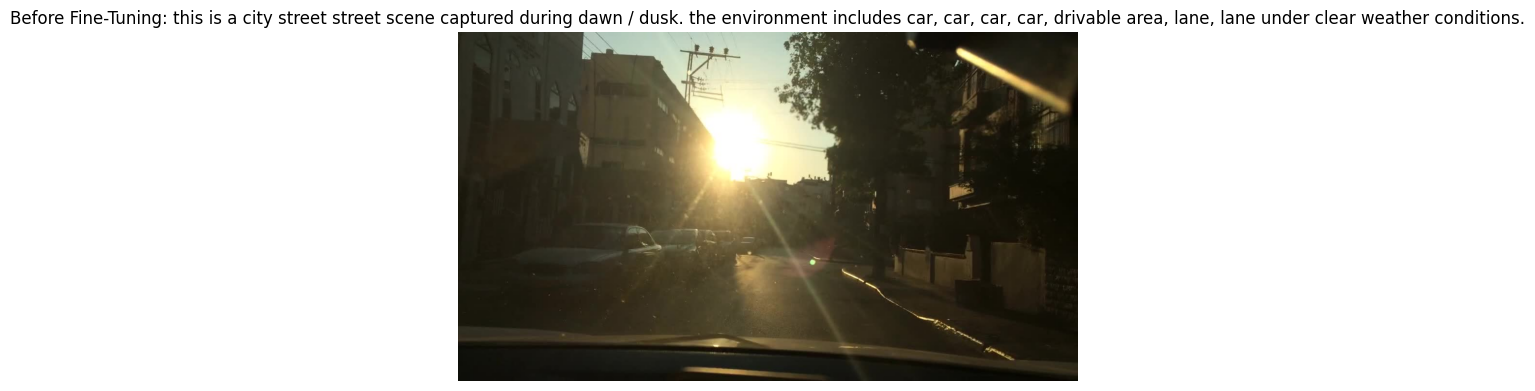

Generating captions after fine-tuning:


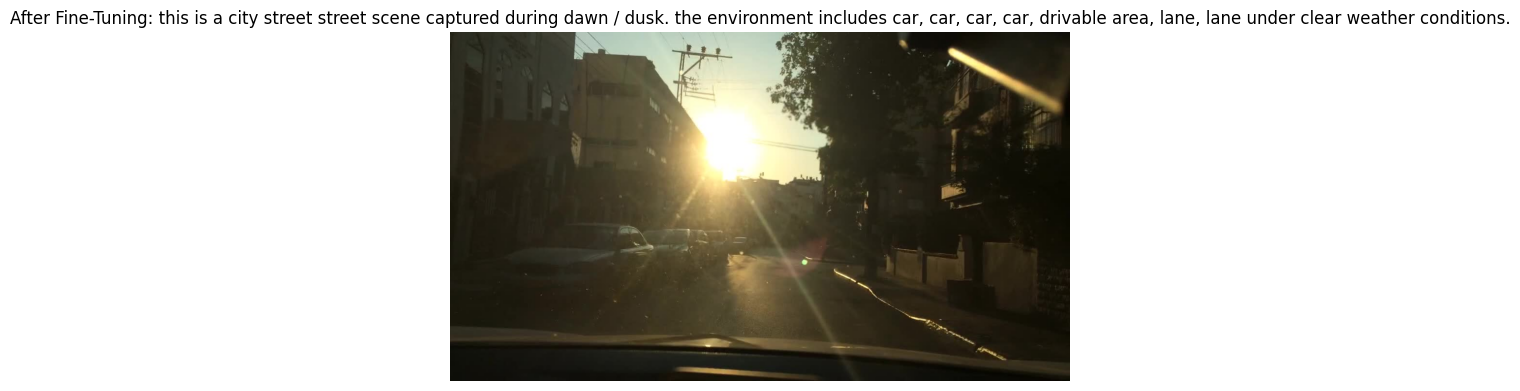

In [22]:
sample_image_path = "/content/drive/MyDrive/bdd100k/images/100k/train/55044be2-5230c30c.jpg"
print("Generating captions before fine-tuning:")
original_caption = generate_caption(sample_image_path, model, "Before Fine-Tuning")
print("Generating captions after fine-tuning:")
fine_tuned_caption = generate_caption(sample_image_path, fine_tuned_model, "After Fine-Tuning")